Evaluate_seg_steatosis_matlab_acc is used to compute the segmentation accuracy of steatosis in matlab-based methods.
The input is different filenames that are used for final testing.
The groundtruth data is in /labs/konglab/Xiaoyuan_Completed/Steatosis_All_in_One/data/GT_mask/stage1_test/.
The segmentation results of the groundtruth data are stored in /labs/konglab/Xiaoyuan_Completed/Steatosis_All_in_One/data/gt_seg_matlab/mask/.

In [1]:
import numpy as np
import pandas as pd
from mrcnn1 import utils
import os
import sys
%matplotlib inline 

In [2]:
filename = '199_24317_67660_1024'

In [3]:
gt_path = '/labs/konglab/Xiaoyuan_Completed/Steatosis_All_in_One/data/GT_mask/stage1_test/'+filename+'/masks/'

In [4]:
path = '/labs/konglab/Xiaoyuan_Completed/Steatosis_All_in_One/data/gt_seg_matlab/mask/'+filename+'_mask/'
path

'/labs/konglab/Xiaoyuan_Completed/Steatosis_All_in_One/data/gt_seg_matlab/mask/199_24317_67660_1024_mask/'

In [5]:
import skimage
mask = []
for f in next(os.walk(path))[2]:
    if f.endswith(".png"):
        m = skimage.io.imread(os.path.join(path, f)).astype(np.bool)
        m = skimage.color.rgb2gray(m)
        mask.append(m)
mask = np.stack(mask, axis=-1)

In [6]:
import skimage
mask_gt = []
for f in next(os.walk(gt_path))[2]:
    if f.endswith(".png"):
        m_gt = skimage.io.imread(os.path.join(gt_path, f)).astype(np.bool)
        m_gt = skimage.color.rgb2gray(m_gt)
        mask_gt.append(m_gt)
mask_gt = np.stack(mask_gt, axis=-1)

In [7]:
mylen=len(mask_gt)
mask.shape

(1024, 1024, 36)

In [8]:
def compute_overlaps_mask(masks1, masks2):
    '''Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    '''
    masks1 = np.reshape(masks1, masks1.shape[-1]*masks1.shape[-1]).astype(np.float32)
    masks2 = np.reshape(masks2, masks2.shape[-1]*masks2.shape[-1]).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1 + area2 - intersections
    overlaps = intersections / union
      
    return overlaps

In [9]:
def compute_ap(gt_masks, pred_masks,iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(gt_masks, pred_masks,iou_threshold)
    print("gt_match length is {}".format(len(gt_match)))

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

In [10]:
def compute_matches( mask_gt,mask,iou_threshold=0.5):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    n= mask.shape[-1]
    Overlaps = np.zeros([n,2])
    for i in range(0,n):
        for j in range(0, mask_gt.shape[-1]):
            overlap=compute_overlaps_mask(mask[:,:,i], mask_gt[:,:,j])
            if (overlap > Overlaps[i,0]):
                Overlaps[i,0] = overlap
                Overlaps[i,1] = j 

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([mask.shape[-1]])
    gt_match = -1 * np.ones([mask_gt.shape[-1]])
    if mask_gt.shape[-1] == 0:
        return gt_match, pred_match, Overlaps
    
    for i in range(mask.shape[-1]):
        # If we reach IoU smaller than the threshold, end the loop
        iou = Overlaps[i,0]
        if iou < iou_threshold:
                continue
        match_count += 1
        ind = Overlaps[i,1].astype(np.int64)
        gt_match[ind] = i
        pred_match[i] = Overlaps[i,1]

    return gt_match, pred_match, Overlaps

In [11]:
AP, precisions, recalls, OverlapS = compute_ap(mask_gt,mask,iou_threshold=0.5)
np.mean(AP), np.mean(precisions), np.mean(recalls),sum(OverlapS[:,0])/len(recalls)

gt_match length is 43


(0.69334000001885121,
 0.90573819690967383,
 0.38984088295776592,
 0.69781542672334529)

In [12]:
import csv
import numpy as np
evaluation_name='evaluation_seg_matlab_10_2.csv'
with open(evaluation_name, 'a') as csvfile:
        fieldnames = ['image_id','num','mean_precision','mean_recall','AP','overlaps']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        #writer.writeheader()
        num = len(recalls)
        writer.writerow({'image_id':filename,'num':num,\
                 'mean_precision':np.mean(precisions),\
                 'mean_recall':np.mean(recalls),'AP':np.mean(AP),'overlaps':sum(OverlapS[:,0])/len(recalls)
                })

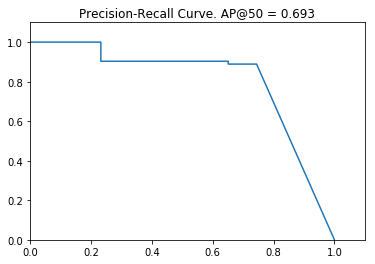

In [14]:
from mrcnn1 import visualize

visualize.plot_precision_recall(AP, precisions, recalls)